# 4. Temporal difference learning

Temporal Difference Learning is a middle ground between Dynamic Programming and Monte Carlo. We don't need an environment model like in dynamic programing but also don't wait until the end of the episode for an update. Bootstraping (using state estimates to backpropagate updates faster) is used. The idea is, if you have backpropagated good estimates from the goal to some state in the middle, why not use this for updates?

### Example for TD(0) / Sarsa
Look one step ahead to update your current state with the immediate reward + the discounted state value of the next state, for the update we uses the current State, Action, Reward, State', Action' --> Sarsa

Input: the policy $\pi$ to be evaluated <br>
Initialize $Q(s,a)$ arbitrarily <br>
Repeat (for each episode): <br>
&emsp;    Initialize s <br>
&emsp;    Repeat (for each step of episode): <br>
&emsp;&emsp;        A <-- action given by $\pi$ for s <br>
&emsp;&emsp;        Taken action A; observe reward, R, and next state, S' <br>
&emsp;&emsp;        $Q(s,a)$ <-- $Q(s,a) + \alpha [R + \gamma  Q(s',a') - Q(s,a)]$ <br>
&emsp;&emsp;        S <-- S' <br>
&emsp;    until S is terminal <br>

For some reason Sarsa is unstable on the 'FrozenLake-v0' env so the Taxi-v2 was used for these tests

In [1]:
import gym
import numpy as np
from collections import deque

env_name = 'Taxi-v2'
env = gym.make(env_name)
state_space = env.observation_space.n
action_space = env.action_space.n

alpha = 0.85
gamma = 0.999
epsilon = 1.0 # amount of exploration
epsilon_decay = 0.99 # exploration decay
num_games = 1500 


q = np.zeros([state_space, action_space])
reward_list = deque(maxlen=100)

def choose_action(q, state, epsilon):
    ''' epsilon-greedy policy (explore with probability epsilon)  '''
    if(np.random.uniform() < epsilon):
        action = np.random.choice(action_space) # exploration
    else:
        action = np.argmax(q[state, :]) # exploitation
    return action

for game in range(num_games):
    state = env.reset()
    action = choose_action(q, state, epsilon)
    epsilon *= epsilon_decay
    done = False
    episode_reward = 0
    
    while(not done):    
        state_next, reward, done, _ = env.step(action)
        episode_reward += reward
        action_next = choose_action(q, state_next, epsilon)
        q[state, action] = q[state, action] + alpha*( reward + gamma*(q[state_next, action_next]) - q[state, action] )
        state = state_next
        action = action_next
        if(done):
            reward_list.append(episode_reward)
            if(game%100 == 0):
                print('avg reward: ', np.mean(reward_list))



avg reward:  -749.0
avg reward:  -568.75
avg reward:  -237.3
avg reward:  -76.55
avg reward:  -27.36
avg reward:  -9.62
avg reward:  -0.31
avg reward:  4.95
avg reward:  6.1
avg reward:  7.26
avg reward:  6.1
avg reward:  6.01
avg reward:  6.34
avg reward:  6.78
avg reward:  6.96


### Example for TD(n)
Instead of only looking one step ahead, calculate the update by looking n steps ahead <br>
The only difference is that we add up the last n discounted rewards <br>
$Q(s,a)$ <-- $Q(s,a) + \alpha [R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+2} + ... + \gamma^n  Q(s',a')_{t+n} - Q(s,a)]$ <br>

#### Implementation detail:
When looking n steps ahead, there is a pitfall which took me quite a while to figure out. <br>
In some gym environments e.g. FrozenLake, are no intermediate rewards and only a +1 reward when reaching the state in the bottom right. <br>
When looking one step ahead this is not much of a problem. At some point the agent will reach a state next to the goal, walk randomly into the goal and update the state value next to it (figure 1.1 to 1.2)
In one of the next episodes the agent might come next to the already updated state and backpropagates the updated state value again (image 1.2 to 1.3). This happens over and over until the state estimates are backpropagated over the entire state space.<br>
<br>
With an n-step lookahead the values could backpropagate even faster, since the agent does not only look at the intermediate reward but a few steps ahead.

When implementing this algorithm you can't realy look ahead so what does the coder do? Save the states, actions, rewards in a list/deque and given those, update the $Q(s,a)$ which lies n steps in the past.

Figure 2.1 shows a 2-step look ahead which packpropagates the +1 reward to the 4th row, 2nd column, so far so good but in which scenario does the 4th row, 3rd column get updated?
In the frozen lake environment G is a terminal state so you would stop the game and never backpropagate the +1 reward from the goal to the 4th row, 3rd column. Given that this state has a value of zero, this error backpropagates like shown in figure 2.2.

A workaround is to not terminate in the goal but rather loop in the terminal state for n steps!

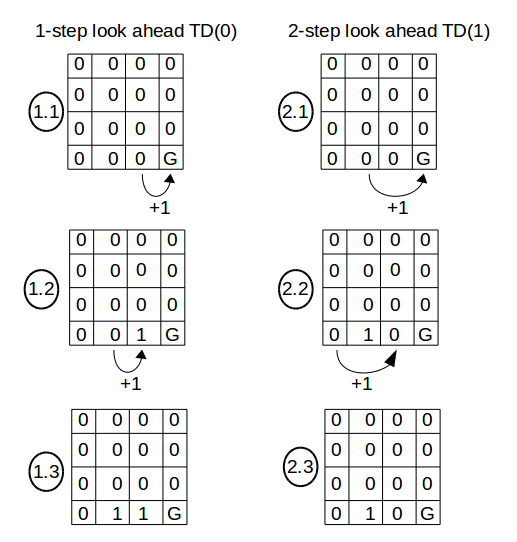

In [2]:
from IPython.display import Image
Image("imgs/td_n_description.png", retina=True)

In [3]:
import gym
import numpy as np
from collections import deque
import itertools

#env_name = 'FrozenLake-v0'
env_name = 'Taxi-v2'
env = gym.make(env_name)
state_space = env.observation_space.n
action_space = env.action_space.n

alpha = 0.85
gamma = 0.999
epsilon = 1.0
epsilon_decay = 0.99
max_games = 1500
n = 7
q = np.zeros([state_space, action_space])
reward_list = deque(maxlen=100)

def calc_g(reward_hist, q_hist, gamma):
    ''' sum the last n discounted rewards + estimate for Q '''
    discounted_rewards = [gamma**(index) * reward for index, reward in enumerate(reward_hist)]
    discounted_q = (gamma**(len(q_hist))) * q_hist[-1] 
    return sum(discounted_rewards) + discounted_q

def choose_action(q, epsilon):
    ''' epsilon-greedy policy (explore with probability epsilon)  '''
    if(np.random.uniform() < epsilon):
        action = np.random.choice(action_space) # exploration
    else:
        action = np.argmax(q[state, :]) # exploitation
    return action

for game in range(max_games):
    reward_hist = deque(maxlen=n)
    q_hist = deque(maxlen=n)
    state_hist = deque(maxlen=n)
    action_hist = deque(maxlen=n)
    
    state = env.reset()
    done=False
    epsilon *= epsilon_decay
    counter = 0
    episode_reward = 0

    while(not done):
        state_hist.append(state)
        action = choose_action(q, epsilon)
        state, reward, done, _ = env.step(action)
        episode_reward += reward
        reward_hist.append(reward)
        q_hist.append(q[state, action]) 
        action_hist.append(action)
        
        past_state = state_hist[0]
        past_action = action_hist[0]
        
        q[past_state, past_action] = q[past_state, past_action] + alpha*( 
            calc_g(reward_hist, q_hist, gamma) - q[past_state, past_action] )
        
        # workaround for terminal state and n-step lookahead, read Implementation detail above the code
        if(done):
            reward_list.append(episode_reward)
            if(game%100 == 0):
                print('avg reward: ', np.mean(reward_list))
            counter += 1
            if counter > (n-1):
                break
        


avg reward:  -839.0
avg reward:  -743.05
avg reward:  -780.87
avg reward:  -685.0
avg reward:  -570.68
avg reward:  -315.14
avg reward:  -181.23
avg reward:  -99.47
avg reward:  -91.09
avg reward:  -46.27
avg reward:  -44.65
avg reward:  -30.35
avg reward:  -46.71
avg reward:  -34.97
avg reward:  -33.17


### Example for TD($\lambda$) / Sarsa($\lambda$)
With a TD(n) the question arises, what is the right n (lookahead) for some environment. TD($\lambda$) deals with this question building a weighted sum over multiple n's <br>
$G_t^\lambda = (1-\lambda)\sum_{n=1}^\inf \lambda^{n-1} G_t^{(n)}$
<br>
For $\lambda=0$ the sum disappears because 0^0 = 1, 0^1 =0, 0^2=0, ... and the formula simplifies to:<br>
$G_t^\lambda = 1 *  G_t^{(0)}$ which is TD(0)<br>
In case of $\lambda=$ approaching 1 we get closer and closer to a Monte Carlo Approach

In [5]:
import gym
import numpy as np
from collections import deque
import itertools

#env_name = 'FrozenLake-v0'
env_name = 'Taxi-v2'
env = gym.make(env_name)
state_space = env.observation_space.n
action_space = env.action_space.n

alpha = 0.85
gamma = 0.999
epsilon = 1.0
epsilon_decay = 0.99
lambd = 0.5
max_games = 1500
n = 7
q = np.zeros([state_space, action_space])
reward_list = deque(maxlen=100)

def calc_g_n(reward_hist, q_hist, gamma):
    ''' sum the last n discounted rewards + estimate for Q '''
    discounted_rewards = [gamma**(index) * reward for index, reward in enumerate(reward_hist)]
    discounted_q = (gamma**(len(q_hist))) * q_hist[-1] 
    return sum(discounted_rewards) + discounted_q

def calc_g_lambda(reward_hist, q_hist, gamma):
    ''' iterate over all lookaheads and build the geometric sum '''
    g_lambda = 0

    for n in range(len(reward_hist)):
        reward_hist1 = list(reward_hist)[:n+1]
        q_hist1 = list(q_hist)[:n+1]
        g_lambda += lambd**n * calc_g_n(reward_hist1, q_hist1, gamma)
    return g_lambda*(1-lambd)
        
def choose_action(q, epsilon):
    ''' epsilon-greedy policy (explore with probability epsilon)  '''
    if(np.random.uniform() < epsilon):
        action = np.random.choice(action_space) # exploration
    else:
        action = np.argmax(q[state, :]) # exploitation
    return action

for game in range(max_games):
    reward_hist = deque(maxlen=n)
    q_hist = deque(maxlen=n)
    state_hist = deque(maxlen=n)
    action_hist = deque(maxlen=n)
    
    state = env.reset()
    epsilon *= epsilon_decay
    counter = 0
    episode_reward = 0
    done=False
    
    while(not done):
        state_hist.append(state)
        action = choose_action(q, epsilon)
        state, reward, done, _ = env.step(action)
        episode_reward += reward
        reward_hist.append(reward)
        q_hist.append((q[state, action])) # adding action values of the current state
        action_hist.append(action)
        
        past_state = state_hist[0]
        past_action = action_hist[0]
        
        q[past_state, past_action] = q[past_state, past_action] + alpha*( 
            calc_g_lambda(reward_hist, q_hist, gamma) - q[past_state, past_action] )
        
        # workaround for terminal state and n-step lookahead, read Implementation detail above the code
        if(done):
            reward_list.append(episode_reward)
            if(game%100 == 0):
                print('avg reward: ', np.mean(reward_list))
            counter += 1
            if counter > (n-1):
                break


avg reward:  -839.0
avg reward:  -569.48
avg reward:  -330.95
avg reward:  -185.02
avg reward:  -89.68
avg reward:  -7.77
avg reward:  -15.3
avg reward:  -10.47
avg reward:  -2.43
avg reward:  1.49
avg reward:  4.25
avg reward:  1.92
avg reward:  4.08
avg reward:  5.14
avg reward:  6.05
